# Opracowanie zbioru danych.

Poniższy zbiór danych jest w istocie próbą stworzenia próbki, która mogłaby odpowiadać występującej w świecie dystrybucji wzrostu, wagi i BMI w grupie 10 tysięcy dorosłych Polek i Polaków (po 5 tysięcy przedstawicieli każdej płci). Znajdujące się w nim dane ciągłe zostały wygenerowane przy użyciu generatora liczb pseudolosowych, jednak w oparciu o rzeczywiste dane dot. średniego wzrostu, wagi i BMI obywateli RP, a także odchyleń standardowych od średnich wartości. Niestety, jakkolwiek dostęp do ww. danych jest dosyć łatwy (chociaż głównie na zagranicznych stronach internetowych), tak te nie zawsze są całkowicie ze sobą spójne. Najbardziej aktualne pomiary średnich wzrostu wagi i BMI pochodzą z roku 2023 (https://worldpopulationreview.com/country-rankings/average-height-by-country i https://www.worlddata.info/average-bodyheight.php), ale w przypadku odchyleń standardowych już trzeba posiłkować się innymi witrynami. Licząc odchylenia standardowe wzrostów i BMI wykorzystałem twórczo tę pracę Marka P. Silvermana z Trinity College: https://digitalrepository.trincoll.edu/cgi/viewcontent.cgi?article=1372&context=facpub. Przyjąłem wynikający z tej pracy stosunek odchyleń standardowych do średnich jako stałe, przez które pomnożyłem aktualnie wyliczone dla polskiej populacji średnie.

Naturalnie rozpoczynamy od zaimportowania niezbędnych bibliotek.

In [1]:
import pandas as pd
import numpy as np
import random
import scipy.stats as scs
import seaborn as sns
import matplotlib.pyplot as plt

Dla stworzenia zbioru danych, jak również ewentualnego wykorzystania w innych celach, tworzymy klasę **Distribution**. Obiekt tej klasy inicjujemy poprzez przekazanie wartości średniej (**avg**), odchylenia standardowego (**stdev**) i liczby próbek (**samples**). Wskazujemy (w polach chronionych) domyślne wartości niektórych atrybutów:
1. **degrees_of_freedom** - stopnie swobody, które wynoszą o jeden mniej niż liczba próbek w razie wywołania rozkładu **t-Studenta**,
2. **distribution_type** - domyślnie rozkład normalny,
3. **skewness** - skośność rozkładu, domyślnie None, możliwa do modyfikacji wyłącznie w razie stworzenia instancji rozkładu **skośnego**.

Wykorzystujemy **dekoratory**: @property i settery, aby zapewnić dostęp do domyślnych wartości i umożliwić ich modyfikację. Kolejnym krokiem jest zdefiniowanie metody **generate_samples**, która generuje próbki na podstawie wybranego typu rozkładu, z wykorzystaniem wartości **PPF** (percent point function, tj. odwrócona dystrybuanta), losowo generującej wartość zmiennej odpowiadającą określonemu procentowi punktowemu w rozkładzie. W zależności od wartości distribution_type (dopuszczalne trzy: "normal", "t" i "skewnorm"), metoda używa odpowiedniej funkcji z modułu scipy.stats do generowania próbek.

In [2]:
class Distribution:
    """
    A class for generating samples from different probability distributions.

    Attributes:
        avg (float): The average value of the distribution.
        stdev (float): The standard deviation of the distribution.
        samples (int): The number of samples to generate.
        degrees_of_freedom (int): The degrees of freedom for the t-distribution (samples - 1).
        distribution_type (str): The type of distribution to generate samples from (default: "normal").
        skewness (float): The skewness parameter for the skewnorm distribution.

    Methods:
        generate_samples(): Generates samples from the specified distribution.

    """

    def __init__(self, avg, stdev, samples):
        """
        Initialize a Distribution object.

        Args:
            avg (float): The average value of the distribution.
            stdev (float): The standard deviation of the distribution.
            samples (int): The number of samples to generate.

        """
        self.avg = avg
        self.stdev = stdev
        self.samples = samples
        self._degrees_of_freedom = samples - 1
        self._distribution_type = "normal"
        self._skewness = None

    @property
    def degrees_of_freedom(self):
        """
        Get the degrees of freedom for the t-distribution.

        Returns:
            int: The degrees of freedom.

        """
        return self._degrees_of_freedom

    @property
    def distribution_type(self):
        """
        Get the current distribution type.

        Returns:
            str: The distribution type.

        """
        return self._distribution_type

    @distribution_type.setter
    def distribution_type(self, value):
        """
        Set the distribution type.

        Args:
            value (str): The distribution type.

        Raises:
            ValueError: If an invalid distribution type is provided.

        """
        if value.lower() in ["normal", "t", "skewnorm"]:
            self._distribution_type = value.lower()
        else:
            raise ValueError("Invalid distribution type. Available options: normal, t, skewnorm.")

    @property
    def skewness(self):
        """
        Get the skewness parameter for the skewnorm distribution.

        Returns:
            float: The skewness parameter.

        """
        return self._skewness

    @skewness.setter
    def skewness(self, value):
        """
        Set the skewness parameter for the skewnorm distribution.

        Args:
            value (float): The skewness parameter.

        """
        self._skewness = value

    def generate_samples(self):
        """
        Generate samples from the specified distribution.

        Returns:
            list: The generated samples.

        """
        distribution = []
        for i in range(self.samples):
            random_p = random.random()
            if self.distribution_type == "normal":
                random_value = scs.norm.ppf(random_p, loc=self.avg, scale=self.stdev)
            elif self.distribution_type == "t":
                random_value = scs.t.ppf(random_p, df=self.degrees_of_freedom, loc=self.avg, scale=self.stdev)
            elif self.distribution_type == "skewnorm":
                random_value = scs.skewnorm.ppf(random_p, self.skewness, loc=self.avg, scale=self.stdev)
            distribution.append(random_value)
        return distribution

Dysponując danymi dot. średnich i odchyleń standardowych rozkładów, tworzymy instancje rozkładów dla wzrostu i BMI. Zauważmy, że nie tworzymy rozkładu mas ciała - zależy nam na możliwie jak najbardziej zbliżonych do rzeczywistości wynikach, a generator liczb pseudolosowych może tworzyć takowe bez związku z realnymi wartościami tej zmiennej. Po utworzeniu obiektów wywołujemy na nich metodę generate_samples, aby stworzyć listy próbek danych. Wybranym przez nas rozkładem jest rozkład **t-Studenta** ("t"). Jest to rozkład podobny do normalnego, ale o szerszych ogonach (czyli o większej zmienności wokół średniej i większym prawdopodobieństwie wystąpienia wartości odstających), szeroko wykorzystywany do statystycznych testów hipotez oraz do budowania przedziałów ufności dla parametrów populacji, gdy próbka jest stosunkowo mała lub gdy wariancja populacji jest nieznana.

In [3]:
male_avg_height = 180.69
male_stdev_height = 7.048
male_avg_bmi = 27.4
male_stdev_bmi = 4

heights_distribution_male = Distribution(male_avg_height, male_stdev_height, 5000)
bmis_distribution_male = Distribution(male_avg_bmi, male_stdev_bmi, 5000)

heights_distribution_male.distribution_type = "t"

bmis_distribution_male.distribution_type = "t"

heights_male = heights_distribution_male.generate_samples()
bmis_male = bmis_distribution_male.generate_samples()

Wygenerowane przez nas listy znajdą się w słowniku **data_m** jako wartości, kluczami zaś będą nazwy kolumn: **"Height"** i **"BMI"**. W trzeciej kolumnie, **"Sex"**, wskazujemy dla wszystkich rekordów płeć męską **"Male"** jako biologiczną. Na podstawie tak przygotowanego słownika stworzymy ramkę danych **df_male**, zawierającą rekordy dot. panów.

In [4]:
data_m = {
    'Height': heights_male,
    'BMI': bmis_male,
    'Sex': 'Male'
}

df_male = pd.DataFrame(data_m)
df_male

,Height,BMI,Sex
0,173.003226,29.696233,Male
1,175.788252,34.240699,Male
2,174.119068,27.570969,Male
3,179.893241,25.899544,Male
4,184.600030,26.724608,Male
...,...,...,...
4995,194.496487,22.133944,Male
4996,166.528631,18.637367,Male
4997,176.899341,25.161286,Male
4998,183.503919,30.100070,Male


Widzimy, że wartości są aż do przesady dokładne, aż do 1/100 mikrometra. Aby ułatwić czytelność (i przede wszystkim sprawić, że wyniki wyglądają realistycznie), zaokrąglimy wzrost do milimetrów, zaś BMI do setnej części.

In [5]:
df_male['Height'] = round(df_male['Height'], 1)
df_male['BMI'] = round(df_male['BMI'], 2)
df_male

,Height,BMI,Sex
0,173.0,29.70,Male
1,175.8,34.24,Male
2,174.1,27.57,Male
3,179.9,25.90,Male
4,184.6,26.72,Male
...,...,...,...
4995,194.5,22.13,Male
4996,166.5,18.64,Male
4997,176.9,25.16,Male
4998,183.5,30.10,Male


Zaokrąglimy również - z dokładnością do jednego miejsca po przecinku - właśnie tworzoną (przez przekształcenie wzoru na BMI) kolumnę z wagami ciała (**"Weight"**).

In [6]:
df_male['Weight'] = round(df_male['BMI'] * (((df_male['Height'])/100)**2), 1)
df_male

,Height,BMI,Sex,Weight
0,173.0,29.70,Male,88.9
1,175.8,34.24,Male,105.8
2,174.1,27.57,Male,83.6
3,179.9,25.90,Male,83.8
4,184.6,26.72,Male,91.1
...,...,...,...,...
4995,194.5,22.13,Male,83.7
4996,166.5,18.64,Male,51.7
4997,176.9,25.16,Male,78.7
4998,183.5,30.10,Male,101.4


Generowanie danych przebiegło pomyślnie, o czym świadczy liczba wartości niepustych i rodzaj danych w każdej z kolumn.

In [7]:
df_male.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Height  5000 non-null   float64
 1   BMI     5000 non-null   float64
 2   Sex     5000 non-null   object 
 3   Weight  5000 non-null   float64
dtypes: float64(3), object(1)
memory usage: 156.4+ KB


Sprawdzamy zatem statystyki opisowe dot. zmiennych wzrostu, BMI i wagi. Tak jak zakładaliśmy, średnie dla rozkładów są bardzo zbliżone do średnich wartości dla całej populacji. Ekstrema dot. zmiennej "BMI" wyglądają na bardzo niepokojące - minimalne BMI na poziomie 14 to wartość odpowiadająca skrajnym wygłodzeniu i wyniszczeniu organizmu, maksymalne - przekraczające 42 - odpowiada zaś tzw. otyłości olbrzymiej. Obie te wartości, jakkolwiek niepokojące, potrafią mieć miejsce w realnym świecie. 

In [8]:
df_male.describe()

,Height,BMI,Weight
count,5000.000000,5000.000000,5000.000000
mean,180.721940,27.410102,89.637600
std,6.942491,4.005581,14.749782
min,157.400000,14.110000,43.500000
25%,176.100000,24.700000,79.400000
50%,180.600000,27.440000,89.100000
75%,185.400000,30.012500,99.100000
max,209.200000,42.890000,167.300000


Analogicznie do powyższego kodu, stworzymy próbkę tej samej wielkości dla pań i nazwiemy zawierający ją data frame **df_female**.

In [9]:
female_avg_height = 165.78
female_stdev_height = 6.535
female_avg_bmi = 26.1
female_stdev_bmi = 3.57

heights_distribution_female = Distribution(female_avg_height, female_stdev_height, 5000)
bmis_distribution_female = Distribution(female_avg_bmi, female_stdev_bmi, 5000)

heights_distribution_female.distribution_type = "t"

bmis_distribution_female.distribution_type = "t"

heights_female = heights_distribution_female.generate_samples()
bmis_female = bmis_distribution_female.generate_samples()

data_f = {
    'Height': heights_female,
    'BMI': bmis_female,
    'Sex': 'Female'
}

df_female = pd.DataFrame(data_f)
df_female['Height'] = round(df_female['Height'], 1)
df_female['BMI'] = round(df_female['BMI'], 2)
df_female['Weight'] = round(df_female['BMI'] * (((df_female['Height'])/100)**2), 1)
df_female

,Height,BMI,Sex,Weight
0,167.2,29.59,Female,82.7
1,157.2,25.17,Female,62.2
2,161.8,23.25,Female,60.9
3,174.3,23.69,Female,72.0
4,163.7,27.39,Female,73.4
...,...,...,...,...
4995,176.0,22.38,Female,69.3
4996,169.0,27.36,Female,78.1
4997,155.7,25.05,Female,60.7
4998,181.3,24.38,Female,80.1


Również tutaj generacja danych przebiegła bez komplikacji. Podobnie jak w przypadku zbioru dot. mężczyzn, średnie są zbliżone do średnich z populacji. Ekstrema dla poszczególnych zmiennych również są odpowiednio niższe.

In [10]:
df_female.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Height  5000 non-null   float64
 1   BMI     5000 non-null   float64
 2   Sex     5000 non-null   object 
 3   Weight  5000 non-null   float64
dtypes: float64(3), object(1)
memory usage: 156.4+ KB


In [11]:
df_female.describe()

,Height,BMI,Weight
count,5000.000000,5000.000000,5000.000000
mean,165.738080,26.150698,71.951440
std,6.556101,3.562199,11.382282
min,139.400000,12.870000,32.700000
25%,161.300000,23.780000,64.300000
50%,165.700000,26.140000,71.800000
75%,170.100000,28.580000,79.200000
max,191.600000,41.780000,127.200000


Wreszcie łączymy nasze zbiory w jeden, który nazwiemy po prostu **df**.

In [12]:
df = pd.concat([df_male, df_female])
df

,Height,BMI,Sex,Weight
0,173.0,29.70,Male,88.9
1,175.8,34.24,Male,105.8
2,174.1,27.57,Male,83.6
3,179.9,25.90,Male,83.8
4,184.6,26.72,Male,91.1
...,...,...,...,...
4995,176.0,22.38,Female,69.3
4996,169.0,27.36,Female,78.1
4997,155.7,25.05,Female,60.7
4998,181.3,24.38,Female,80.1


Po złączeniu powstała ramka danych zawierająca 10000 rekordów. Średnie w poszczególnych kolumnach uległy swego rodzaju uśrednieniu, wyraźnie wzrosły - ze względu na większą wariancję w całym zbiorze - odchylenia standardowe dla wzrostu i wagi, wartości ekstremalne się nawzajem uzupełniają.

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 4999
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Height  10000 non-null  float64
 1   BMI     10000 non-null  float64
 2   Sex     10000 non-null  object 
 3   Weight  10000 non-null  float64
dtypes: float64(3), object(1)
memory usage: 390.6+ KB


In [14]:
df.describe()

,Height,BMI,Weight
count,10000.000000,10000.000000,10000.000000
mean,173.230010,26.780400,80.794520
std,10.085653,3.842148,15.866529
min,139.400000,12.870000,32.700000
25%,165.500000,24.180000,69.400000
50%,173.100000,26.735000,79.300000
75%,180.800000,29.270000,91.200000
max,209.200000,42.890000,167.300000


Na samym końcu tej sekcji zapisujemy zbiór danych w pliku w formacie **.csv**. Ustawiamy wartość parametru index na False, żeby uniknąć problemu z wczytaniem indeksów (ze względu na połączenie dwóch zbiorów mamy podwójną indeksację od 0 do 4999, w wygenerowanym zbiorze ten problem zanika).

In [15]:
df.to_csv('Polish_height_weight_bmi.csv', index=False)

Ponieważ ta podwójna indeksacja nam się nie podoba, również i ją usuwamy (choć ze względu na charakter projektu nie jest to szczególnie konieczne).

In [16]:
df.reset_index(drop=True, inplace=True)
df

,Height,BMI,Sex,Weight
0,173.0,29.70,Male,88.9
1,175.8,34.24,Male,105.8
2,174.1,27.57,Male,83.6
3,179.9,25.90,Male,83.8
4,184.6,26.72,Male,91.1
...,...,...,...,...
9995,176.0,22.38,Female,69.3
9996,169.0,27.36,Female,78.1
9997,155.7,25.05,Female,60.7
9998,181.3,24.38,Female,80.1


# Analiza zbioru danych.

Oczywistym jest, że analizie podlegać będą wyłącznie kolumny zawierające wartości liczbowe, ale pomocniczo (aby sprawdzić np. rozkład danych ze względu na płeć) będziemy stosować wartości dotyczące płci - bądź to z kolumny "Sex" w ramce danych df, bądź to ze wstępnie zdefiniowanych ramek df_male i df_female.

In [17]:
continuous_cols = list(df.drop(columns='Sex').columns)
continuous_cols

['Height', 'BMI', 'Weight']

Rozkłady wszystkich zmiennych na pierwszy rzut oka przypominają w obu przypadkach rozkłady normalne, z cienkimi ogonami i mocną koncentracją danych wokół zmiennej. Zastosowanie w tym wypadku rozkładu t-Studenta nie było zgodne z konwencją, wg której dla próby o rozmiarze > 30 stosować się powinno aproksymację rozkładem normalnym. Miałem w tym jednak swój cel - chciałem zademonstrować, że przy próbie o znacznej wielkości zastosowany rozkład staje się praktycznie **nieodróżnialny od Gaussowskiego**.

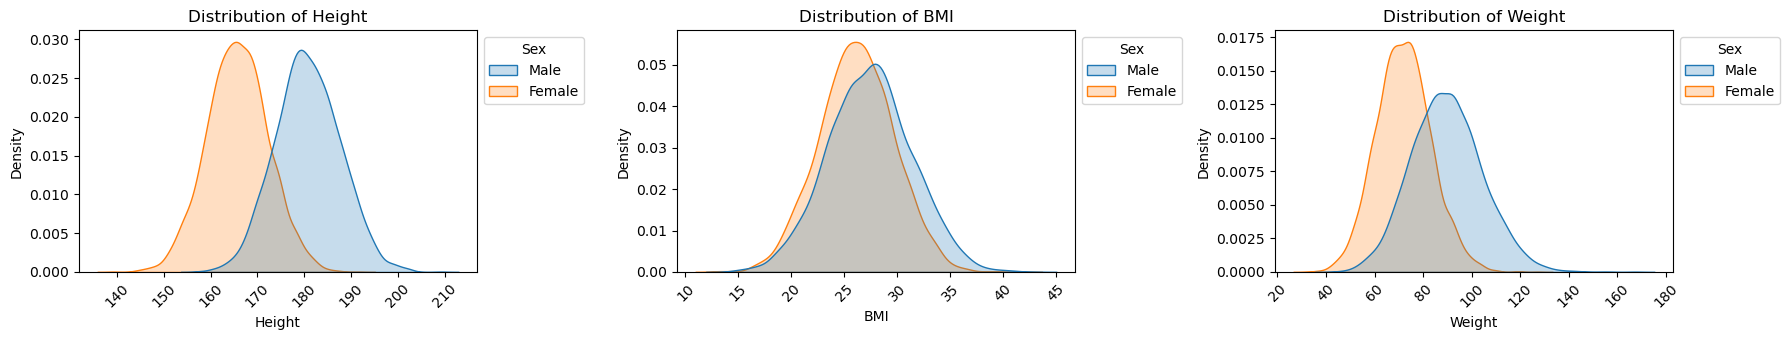

In [18]:
rotation = 45
legend = (1, 1)
figsize = (6, 3.5)

fig, axes = plt.subplots(1, 3, figsize=(18, 3.5)) 

for i, col in enumerate(continuous_cols):
    plt.subplot(1, 3, i+1) 
    ax = sns.kdeplot(x=col, data=df,
                     hue='Sex', fill=True, multiple='layer')
    sns.move_legend(ax, "upper left", bbox_to_anchor=legend)
    plt.xticks(rotation=rotation)
    plt.title(f'Distribution of {col}')

plt.tight_layout()
plt.show()

Skoro rozkłady są bardzo zbliżone do normalnych, to i ich **dystrubuanty** przybierają kształt sigmoid. Odnotować też musimy, że symetrię tych sigmoid zaburzają wartości odstające z prawej strony krzywej - znaczy to, że bardziej skrajne outliery w rozkładach występują wśród bardzo wysokich wartości.

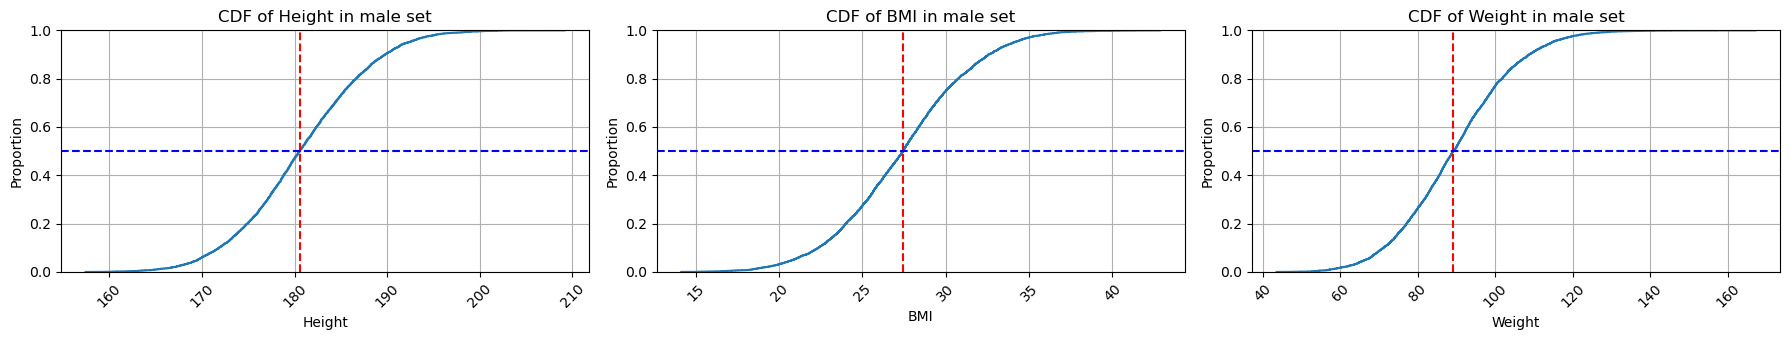

In [19]:
rotation = 45
legend = (1, 1)
figsize = (6, 3.5)

fig, axes = plt.subplots(1, 3, figsize=(18, 3.5)) 

for i, col in enumerate(continuous_cols):
    plt.subplot(1, 3, i+1) 
    ax = sns.ecdfplot(x=col, data=df_male)
    plt.xticks(rotation=rotation)
    plt.grid(True)
    plt.title(f'CDF of {col} in male set')
    median = df_male[col].median()
    plt.axvline(median, color='red', linestyle='--')
    plt.axhline(0.5, color='blue', linestyle='--')

plt.tight_layout()
plt.show()

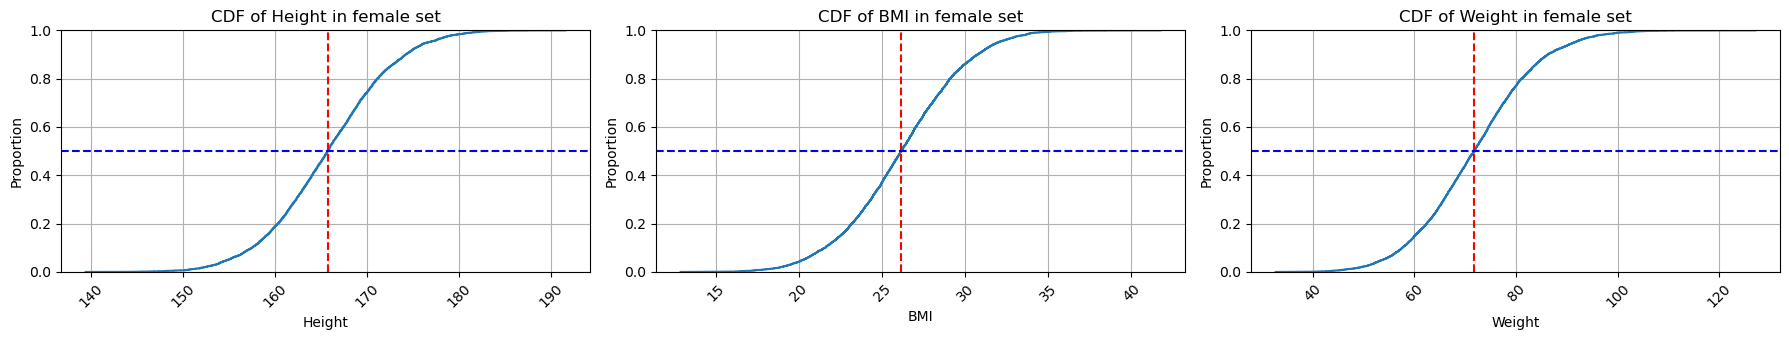

In [20]:
rotation = 45
legend = (1, 1)
figsize = (6, 3.5)

fig, axes = plt.subplots(1, 3, figsize=(18, 3.5)) 

for i, col in enumerate(continuous_cols):
    plt.subplot(1, 3, i+1) 
    ax = sns.ecdfplot(x=col, data=df_female)
    plt.xticks(rotation=rotation)
    plt.grid(True)
    plt.title(f'CDF of {col} in female set')
    median = df_female[col].median()
    plt.axvline(median, color='red', linestyle='--')
    plt.axhline(0.5, color='blue', linestyle='--')

plt.tight_layout()
plt.show()

**Wykresy pudełkowe** dają nam bardziej wyraźny obraz co do rozstępów między 1. i 3. kwartylem oraz outlierów dla poszczególnych zmiennych. I tak np. znaczny jest "rozstrzał" między wartościami odstającymi powyżej górnego wąsa wykresu dot. rozkładu wag dla mężczyzn: górny wąs sięga ok. 130 kg, a wartości odstające ciągną się wyraźnie ponad 160 kg (przy rozstępie międzyćwiartkowym od ok. 80 do ok. 100 kg).

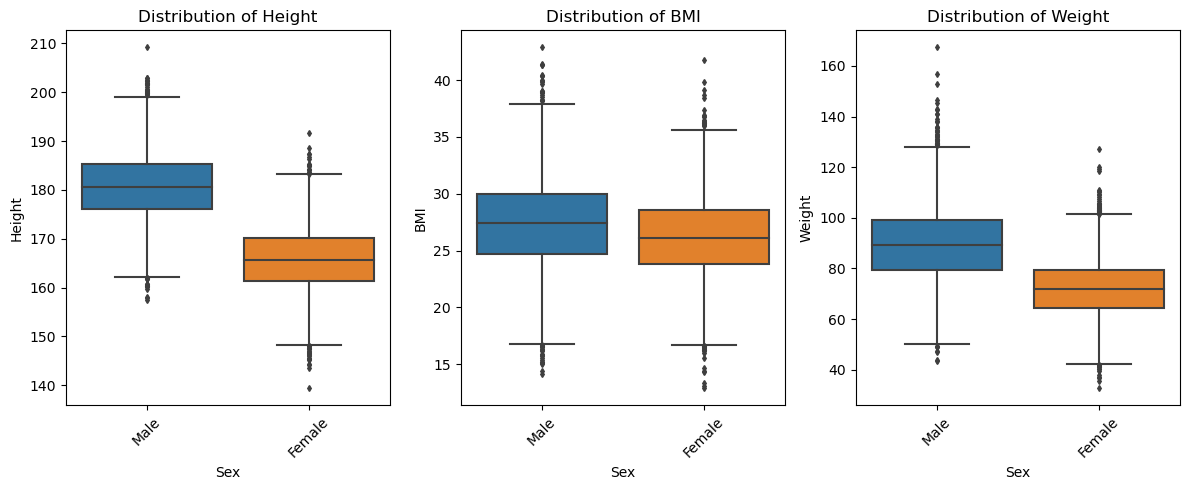

In [21]:
rotation = 45
figsize = (4, 5)

fig, axes = plt.subplots(1, 3, figsize=(12, 5))  

for i, col in enumerate(continuous_cols):
    ax = axes[i]
    ax = sns.boxplot(x='Sex', y=col, data=df, fliersize=3, ax=ax)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=rotation)
    ax.set_title(f'Distribution of {col}')

plt.tight_layout()
plt.show()

Za pomocą **wykresów punktowych** sprawdzamy zależności między poszczególnymi zmiennymi ciągłymi. Linie wygenerowane przez funkcję regplot pozwalają nam nawet na prostą wizualizację regresji między poszczególnymi zmiennymi. Ciekawie wygląda pod tym względem zależność między BMI a wzrostem; u pań przeciętne BMI nie rośnie, im wyższy jest wzrost, a u panów nawet maleje.

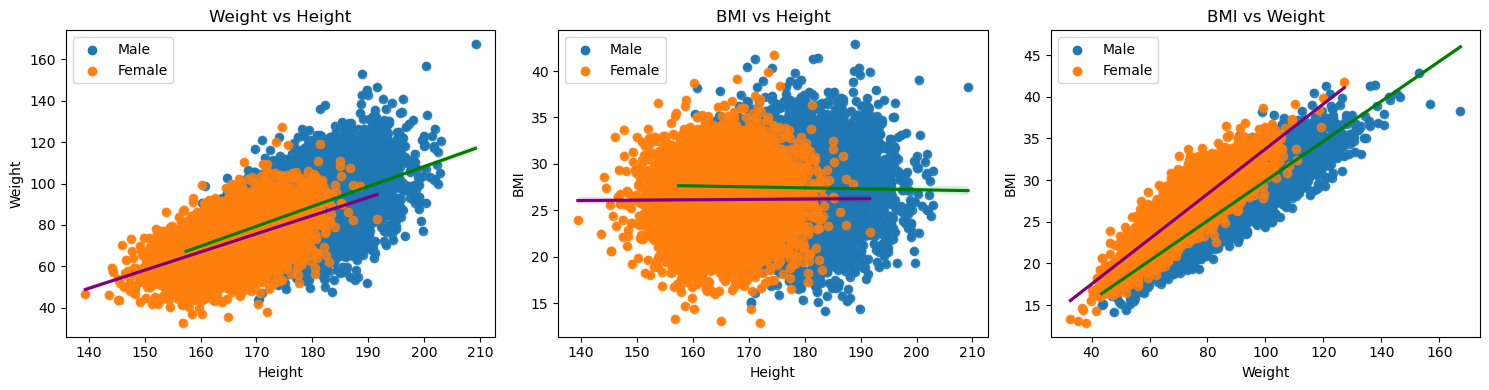

In [22]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

ax1 = axes[0]
sns.scatterplot(x='Height', y='Weight', hue='Sex', data=df, ax=ax1)
sns.regplot(x='Height', y='Weight', data=df[df['Sex'] == 'Male'], ax=ax1, line_kws={'linestyle': 'solid', 'color': 'green'})
sns.regplot(x='Height', y='Weight', data=df[df['Sex'] == 'Female'], ax=ax1, line_kws={'linestyle': 'solid', 'color': 'purple'})
ax1.set_xlabel('Height')
ax1.set_ylabel('Weight')
ax1.set_title('Weight vs Height')
ax1.legend()

ax2 = axes[1]
sns.scatterplot(x='Height', y='BMI', hue='Sex', data=df, ax=ax2)
sns.regplot(x='Height', y='BMI', data=df[df['Sex'] == 'Male'], ax=ax2, line_kws={'linestyle': 'solid', 'color': 'green'})
sns.regplot(x='Height', y='BMI', data=df[df['Sex'] == 'Female'], ax=ax2, line_kws={'linestyle': 'solid', 'color': 'purple'})
ax2.set_xlabel('Height')
ax2.set_ylabel('BMI')
ax2.set_title('BMI vs Height')
ax2.legend()

ax3 = axes[2]
sns.scatterplot(x='Weight', y='BMI', hue='Sex', data=df, ax=ax3)
sns.regplot(x='Weight', y='BMI', data=df[df['Sex'] == 'Male'], ax=ax3, line_kws={'linestyle': 'solid', 'color': 'green'})
sns.regplot(x='Weight', y='BMI', data=df[df['Sex'] == 'Female'], ax=ax3, line_kws={'linestyle': 'solid', 'color': 'purple'})
ax3.set_xlabel('Weight')
ax3.set_ylabel('BMI')
ax3.set_title('BMI vs Weight')
ax3.legend()

plt.tight_layout()
plt.show()

Bardziej szczegółowych informacji udzielają nam **macierze korelacji**. Tak jak wynikać może z wykresów punktowych: BMI jest w obu zbiorach mocno skorelowane z wagą, korelacje wzrostu i wagi są średniej wysokości, zaś korelacje BMI i wzrostu są znikome.

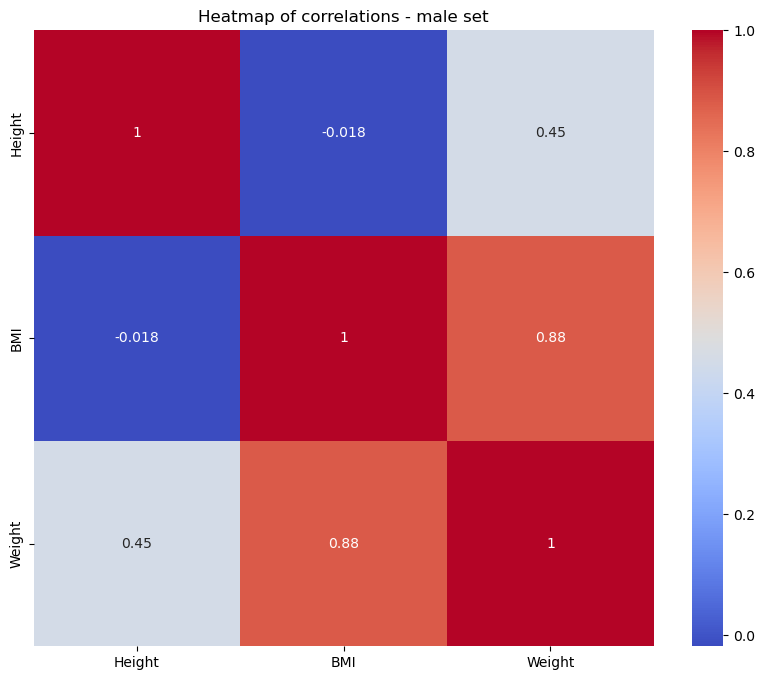

In [23]:
correlation_matrix = df_male[continuous_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Heatmap of correlations - male set')
plt.show()

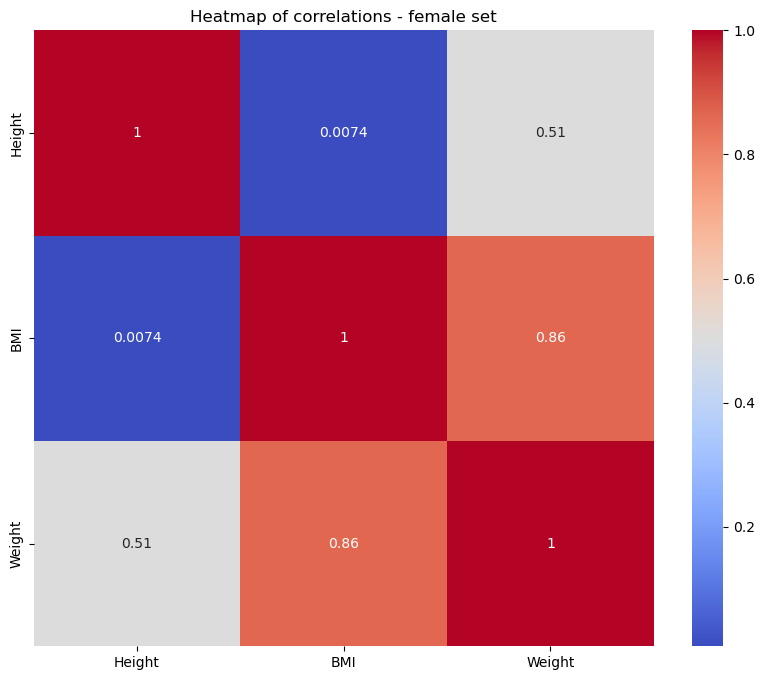

In [24]:
correlation_matrix = df_female[continuous_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Heatmap of correlations - female set')
plt.show()

Zwizualizujemy również statystyki opisowe dla zbiorów dot. mężczyzn i kobiet, opierając się na funkcji describe, której zamiast domyślnie ustawionych kwartyli nakażemy wskazać wartości znajdujące się - zgodnie z tzw. **regułą trzech sigm** - w odległości jednego, dwóch i trzech odchyleń standardowych od mediany (ze wskazaniem zwyczajowo przyjętych dla tej reguły percentyli).

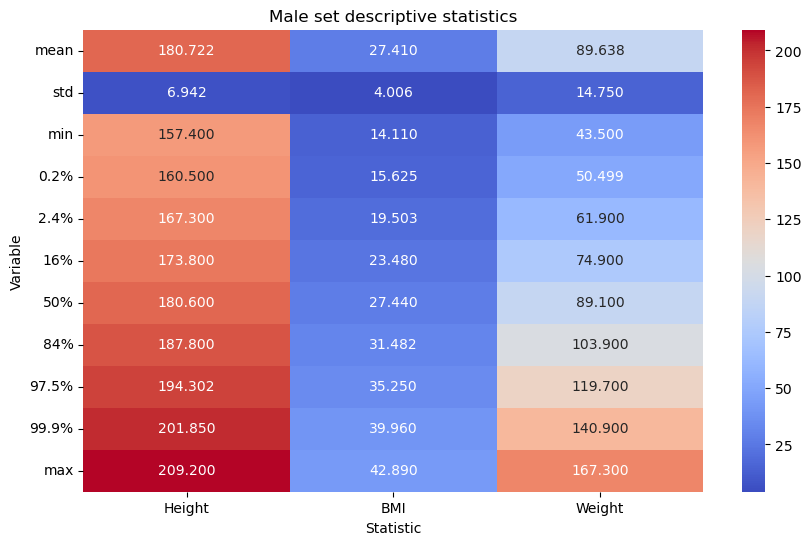

In [25]:
three_sigmas = [0.0015, 0.0235, 0.16, 0.5, 0.84, 0.975, 0.9985]

plt.figure(figsize=(10, 6))
sns.heatmap(df_male.describe(percentiles=three_sigmas).drop('count'), annot=True, fmt=".3f", cmap='coolwarm')
plt.xlabel('Statistic')
plt.ylabel('Variable')
plt.title('Male set descriptive statistics')
plt.show()

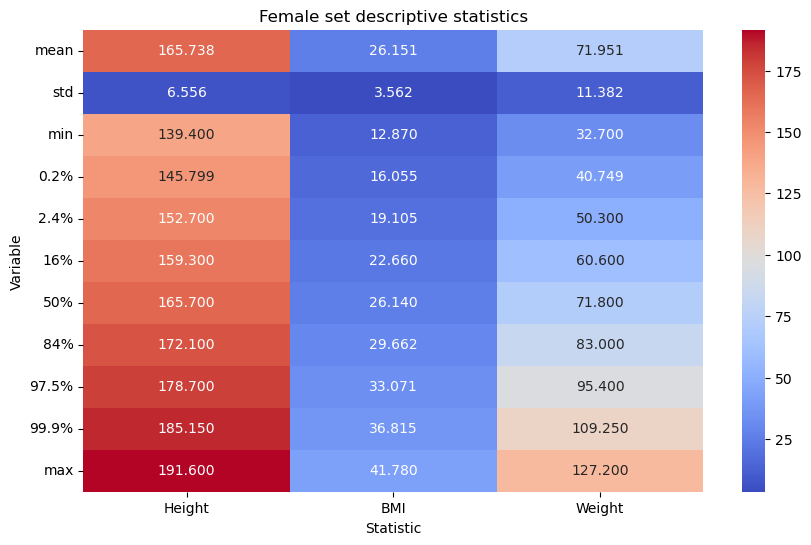

In [26]:
plt.figure(figsize=(10, 6))
sns.heatmap(df_female.describe(percentiles=three_sigmas).drop('count'), annot=True, fmt=".3f", cmap='coolwarm')
plt.xlabel('Statistic')
plt.ylabel('Variable')
plt.title('Female set descriptive statistics')
plt.show()

Na koniec tej sekcji zdefiniujmy, a następnie wypróbujmy dwie funkcje:
1. **normality_testing** - służy sprawdzeniu normalności rozkładu wg testów Shapiro-Wilka, D'Agostino-Pearsona i Andersona-Darlinga, a także wypisaniu skośności i kurtozy rozkładu,
2. **distributions_comparison** - służy porównaniu (przy użyciu t-testu i testu Kołmogorowa-Smirnowa dla dwóch próbek) dwóch rozkładów dot. tej samej zmiennej i zbadaniu, czy różnice między tymi rozkładami są istotne statystycznie.

In [27]:
def normality_testing(data, columns: list):
    for col in columns:
        column_data = data[col]
        stat_sw, p_value_sw = scs.shapiro(column_data)
        stat_ap, p_value_ap = scs.normaltest(column_data)
        stats_and = scs.anderson(column_data, dist='norm')
        skewness = scs.skew(column_data)
        kurtosis = scs.kurtosis(column_data)
    
        print(f"Column '{col}':\n")
        print(f"Shapiro-Wilk test statistic: {stat_sw}")
        print(f"Shapiro-Wilk p-value: {p_value_sw}")
        print("------------------------------------")
        print(f"D'Agostino-Pearson test statistic: {stat_ap}")
        print(f"D'Agostino-Pearson p-value: {p_value_ap}")
        print("------------------------------------")
        print(f"Anderson-Darling test statistic: {stats_and.statistic}")
        print(f"Anderson-Darling critical values: {stats_and.critical_values}")
        print(f"Anderson-Darling significance level: {stats_and.significance_level}")
        print("------------------------------------")
        print(f"Skewness: {skewness}")
        print(f"Kurtosis: {kurtosis}")
        print("------------------------------------\n")
        
def distributions_comparison(x, y, columns: list):
    for col in columns:
        data_x = x[col]
        data_y = y[col]
        stat, p_value = scs.ttest_ind(data_x, data_y)
        ks_stat, ks_p_value = scs.ks_2samp(data_x, data_y)
        print(f"Column {col}:")
        print(f"T-test statistic: {stat}")
        print(f"T-test p-value: {p_value}")
        print("------------------------------------")
        print(f"KS test statistic: {ks_stat}")
        print(f"KS test p-value: {ks_p_value}")
        print("------------------------------------\n")

Jeżeli chodzi o zbiór dot. mężczyzn:

1. Kolumna **'Height'**:
Wyniki testów normalności dla kolumny 'Height' wskazują na brak przekonujących dowodów na odrzucenie hipotezy o normalnym rozkładzie wartości. Test Shapiro-Wilka i test D'Agostino-Pearsona mają wysokie wartości p-value, co sugeruje, że rozkład wartości może być zbliżony do normalnego. Wynik testu Andersona-Darlinga wskazuje na niską wartość statystyki testowej w porównaniu do krytycznych wartości, co również sugeruje, że rozkład tej może być zbliżony do Gaussowskiego. Skośność (skewness) i kurtoza (kurtosis) są bliskie zeru, co wskazuje na brak znaczących odchyleń od rozkładu normalnego.

2. Kolumna **'BMI'**:
Również w tym wypadku wyniki testów normalności nie dostarczają silnych dowodów na odrzucenie hipotezy zerowej. Wartości p-value dla testów Shapiro-Wilk i D'Agostino-Pearson są wysokie, a test Andersona-Darlinga wykazuje niską wartość statystyki testowej w porównaniu do krytycznych wartości. Skośność i kurtoza są minimalne.

3. Kolumna **'Weight'**:
Tu sytuacja jest zgoła odmienna. Wyniki testów normalności dla kolumny 'Weight' jednoznacznie wskazują na odrzucenie hipotezy o normalnym rozkładzie wartości. Wartości p-value dla testów Shapiro-Wilk i D'Agostino-Pearson są bardzo niskie (poniżej progu 0,05, pozwalającego na przyjęcie hipotezy zerowej). Test Andersona-Darlinga wykazuje wysoką wartość statystyki testowej w porównaniu do krytycznych wartości, zaś skośność i kurtoza również wskazują na znaczne odstępstwa.

In [28]:
normality_testing(df_male, continuous_cols)

Column 'Height':

Shapiro-Wilk test statistic: 0.9994427561759949
Shapiro-Wilk p-value: 0.13980187475681305
------------------------------------
D'Agostino-Pearson test statistic: 4.607146038099116
D'Agostino-Pearson p-value: 0.09990125617827708
------------------------------------
Anderson-Darling test statistic: 0.7229356717416522
Anderson-Darling critical values: [0.576 0.655 0.786 0.917 1.091]
Anderson-Darling significance level: [15.  10.   5.   2.5  1. ]
------------------------------------
Skewness: 0.07363827024093597
Kurtosis: -0.02368639276573381
------------------------------------

Column 'BMI':

Shapiro-Wilk test statistic: 0.9996215105056763
Shapiro-Wilk p-value: 0.4735844135284424
------------------------------------
D'Agostino-Pearson test statistic: 1.9573723411947503
D'Agostino-Pearson p-value: 0.3758045176713025
------------------------------------
Anderson-Darling test statistic: 0.4307351357456355
Anderson-Darling critical values: [0.576 0.655 0.786 0.917 1.091]
An

Z kolei, jeżeli chodzi o panie, sytuacja dot. rozkładów jest bardzo zbliżona:

1. Kolumna **'Height'**:
Wyniki testów normalności (Shapiro-Wilk, D'Agostino-Pearson, Anderson-Darling) wskazują na brak przekonujących dowodów na odrzucenie hipotezy o normalnym rozkładzie wartości. Wartości p-value są wysokie (bliskie 1) dla testów Shapiro-Wilk i D'Agostino-Pearson, co sugeruje, że rozkład wartości najprawdopodobniej jest zbliżony do normalnego. Test Andersona-Darlinga wykazuje niską wartość statystyki testowej w porównaniu do krytycznych wartości, a skośność i kurtoza również wskazują na brak znaczących odchyleń od rozkładu normalnego.

2. Kolumna **'BMI'**:
Wyniki testów normalności dla kolumny 'BMI' również nie dostarczają silnych dowodów na odrzucenie hipotezy zerowej. Wartości p-value dla testów Shapiro-Wilk i D'Agostino-Pearson są wysokie. Test Andersona-Darlinga wykazuje niską wartość statystyki testowej w porównaniu do krytycznych wartości. Skośność i kurtoza wskazują na niewielkie odchylenia od rozkładu normalnego.

3. Kolumna **'Weight'**:
Dla tej kolumny wyniki testów normalności wskazują na istotne odstępstwa od założenia o normalnym rozkładzie wartości. Wartości p-value dla testów Shapiro-Wilk i D'Agostino-Pearson są bardzo niskie, co sugeruje odrzucenie hipotezy o normalnym rozkładzie, podobnie test Andersona-Darlinga wykazuje wysoką wartość statystyki testowej w porównaniu do krytycznych wartości. Skośność i kurtoza również wskazują na znaczne odstępstwa od rozkładu Gaussa.

In [29]:
normality_testing(df_female, continuous_cols)

Column 'Height':

Shapiro-Wilk test statistic: 0.9997760057449341
Shapiro-Wilk p-value: 0.9049086570739746
------------------------------------
D'Agostino-Pearson test statistic: 1.0160083505311928
D'Agostino-Pearson p-value: 0.6016952595193481
------------------------------------
Anderson-Darling test statistic: 0.3367791064792982
Anderson-Darling critical values: [0.576 0.655 0.786 0.917 1.091]
Anderson-Darling significance level: [15.  10.   5.   2.5  1. ]
------------------------------------
Skewness: 0.01788223199087124
Kurtosis: 0.057858835090575766
------------------------------------

Column 'BMI':

Shapiro-Wilk test statistic: 0.9996482133865356
Shapiro-Wilk p-value: 0.5500267148017883
------------------------------------
D'Agostino-Pearson test statistic: 1.337732866054498
D'Agostino-Pearson p-value: 0.512288962620386
------------------------------------
Anderson-Darling test statistic: 0.20055193595271703
Anderson-Darling critical values: [0.576 0.655 0.786 0.917 1.091]
Ande

Wszystkie testy dla wszystkich zmiennych wskazują na wyraźne i istotne różnice między rozkładami dla kobiet i mężczyzn. Wskazują na to wysokie wartości statystyk testowych i p-wartości poniżej 0,05.

In [30]:
distributions_comparison(df_male, df_female, continuous_cols)

Column Height:
T-test statistic: 110.95768914535296
T-test p-value: 0.0
------------------------------------
KS test statistic: 0.7346
KS test p-value: 0.0
------------------------------------

Column BMI:
T-test statistic: 16.61316788359349
T-test p-value: 3.681907131951993e-61
------------------------------------
KS test statistic: 0.1436
KS test p-value: 2.3579322194619147e-45
------------------------------------

Column Weight:
T-test statistic: 67.12487398751159
T-test p-value: 0.0
------------------------------------
KS test statistic: 0.5126
KS test p-value: 0.0
------------------------------------



# Porównanie próbek dot. reprezentacji piłkarskich z wygenerowanymi rozkładami.

Zasadniczy cel tego projektu został spełniony - wygenerowaliśmy całkiem liczny i nieźle oddający rzeczywistość zbiór danych dot. warunków fizycznych Polaków. Na deser zostawimy sobie jednak porównanie z tym zbiorem dwóch pomniejszych próbek danych dot. polskich piłkarzy i piłkarek. Pierwszy z nich będzie zawierał wzrosty, wagi i BMI polskich piłkarzy, którzy uczestniczyli w Mistrzostwach Świata 2022 w Katarze (26 zawodników). Drugi zaś zawierać będzie tożsame dane najlepszych polskich piłkarek - łącznie 27 zawodniczek, w tym 15 piłkarek aktualnych mistrzyń kraju, czyli GKS Katowice, i 12 reprezentantek Polski z innych zespołów. Porównamy zatem niewielkie zbiory danych rzeczywistych z dużym zbiorem danych losowo wygenerowanych.

Najpierw stworzymy i poddamy odpowiedniej obróbce zbiór dot. panów.

In [31]:
male_polish_football_team = {
    'Height': [196, 187, 195, 185, 189, 187, 189, 189, 190, 183,
               182, 189, 185, 187, 185, 174, 180, 175, 186, 185,
               180, 179, 184, 183, 176, 173],
    'Weight': [92, 83, 87, 79, 83, 80, 84, 76, 86, 75, 74, 83, 75,
               82, 79, 62, 76, 68, 82, 79, 76, 69, 74, 78, 68, 66]
}

df_mfoot = pd.DataFrame.from_dict(male_polish_football_team)
df_mfoot

,Height,Weight
0,196,92
1,187,83
2,195,87
3,185,79
4,189,83
5,187,80
6,189,84
7,189,76
8,190,86
9,183,75


In [32]:
df_mfoot['BMI'] = df_mfoot['Weight'] / ((df_mfoot['Height']/100)**2)
df_mfoot['BMI'] = round(df_mfoot['BMI'], 2)
df_mfoot

,Height,Weight,BMI
0,196,92,23.95
1,187,83,23.74
2,195,87,22.88
3,185,79,23.08
4,189,83,23.24
5,187,80,22.88
6,189,84,23.52
7,189,76,21.28
8,190,86,23.82
9,183,75,22.40


Jak wynika z samych statystyk opisowych, przeciętny wzrost piłkarzy jest powyżej, zaś waga i BMI poniżej średniej z naszej wygenerowanej losowo próbki.

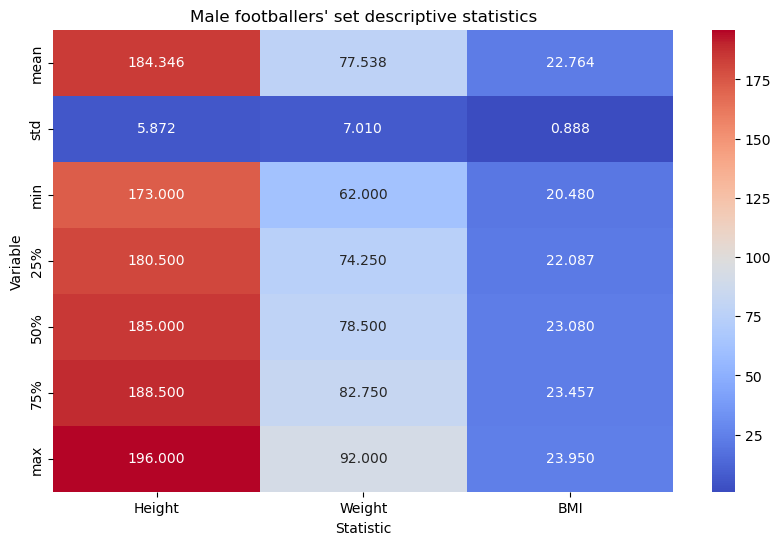

In [33]:
plt.figure(figsize=(10, 6))
sns.heatmap(df_mfoot.describe().drop('count'), annot=True, fmt=".3f", cmap='coolwarm')
plt.xlabel('Statistic')
plt.ylabel('Variable')
plt.title("Male footballers' set descriptive statistics")
plt.show()

Rozkłady dla próbki, ze względu na ich nieduży rozmiar, zwizualizujemy przy pomocy histogramów. Wydawać się może, że jakkolwiek próbki te nie "układają się" ściśle w kształt rozkładu normalnego, tak mogą one z takowego rozkładu pochodzić.

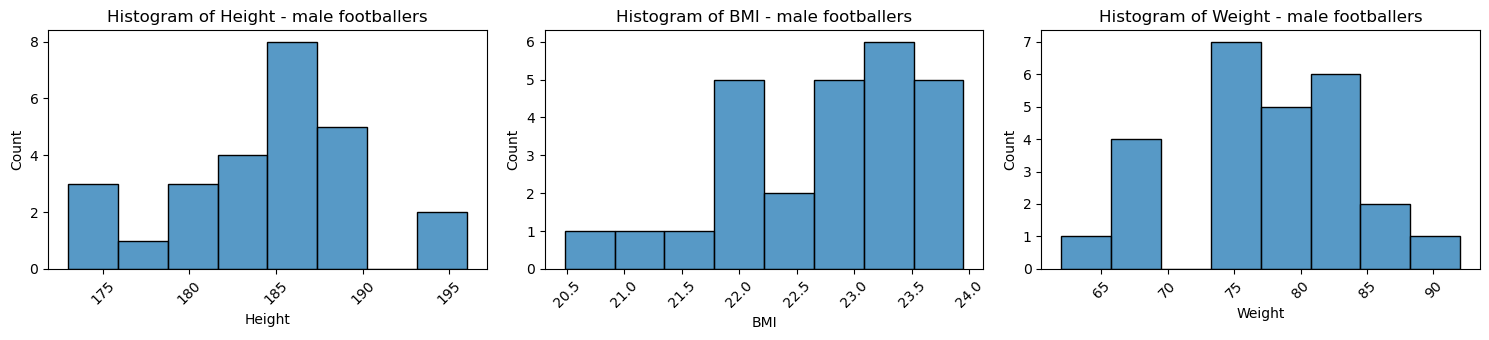

In [34]:
rotation = 45
legend = (1, 1)
figsize = (5, 3.5)

fig, axes = plt.subplots(1, 3, figsize=(15, 3.5)) 

for i, col in enumerate(continuous_cols):
    plt.subplot(1, 3, i+1) 
    ax = sns.histplot(x=col, data=df_mfoot, bins=8)
    plt.xticks(rotation=rotation)
    plt.title(f'Histogram of {col} - male footballers')

plt.tight_layout()
plt.show()

Również dystrybuanty przybierają kształt łamanych sigmoid, co może sugerować pochodzenie próbki z większej populacji o rozkładzie normalnym.

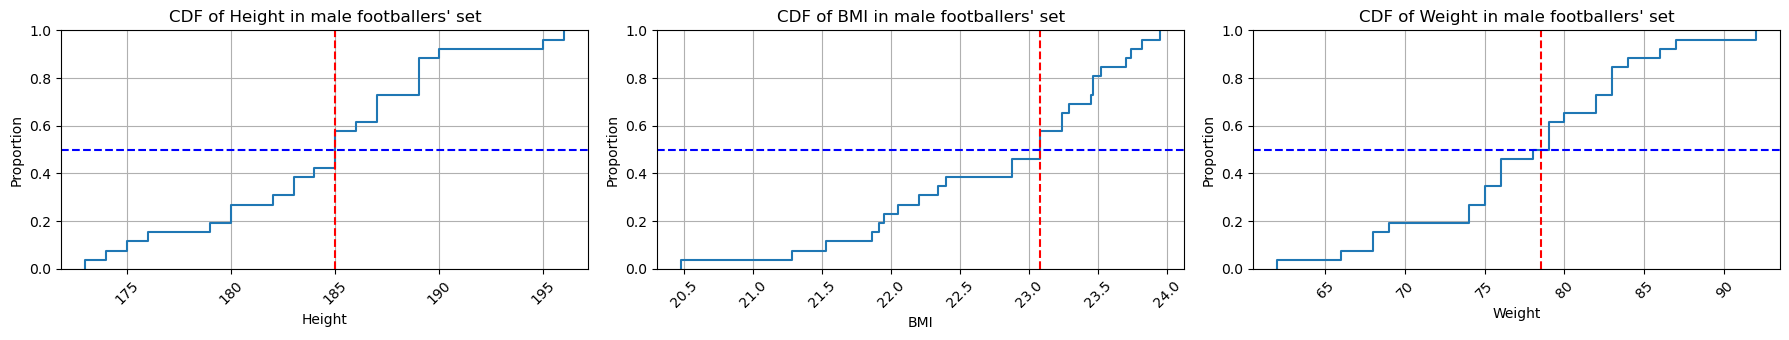

In [35]:
rotation = 45
legend = (1, 1)
figsize = (6, 3.5)

fig, axes = plt.subplots(1, 3, figsize=(18, 3.5)) 

for i, col in enumerate(continuous_cols):
    plt.subplot(1, 3, i+1) 
    ax = sns.ecdfplot(x=col, data=df_mfoot)
    plt.xticks(rotation=rotation)
    plt.grid(True)
    plt.title(f"CDF of {col} in male footballers' set")
    median = df_mfoot[col].median()
    plt.axvline(median, color='red', linestyle='--')
    plt.axhline(0.5, color='blue', linestyle='--')

plt.tight_layout()
plt.show()

Wykres punktowy wzrostu i wagi wskazuje na wyraźną zależność liniową między wzrostem i wagą piłkarzy, jak i nieco mniej wyraźną zależność między BMI a wagą. Ogólnie między wszystkimi poszczególnymi zmiennymi zachodzą co najmniej dość wysokie korelacje.

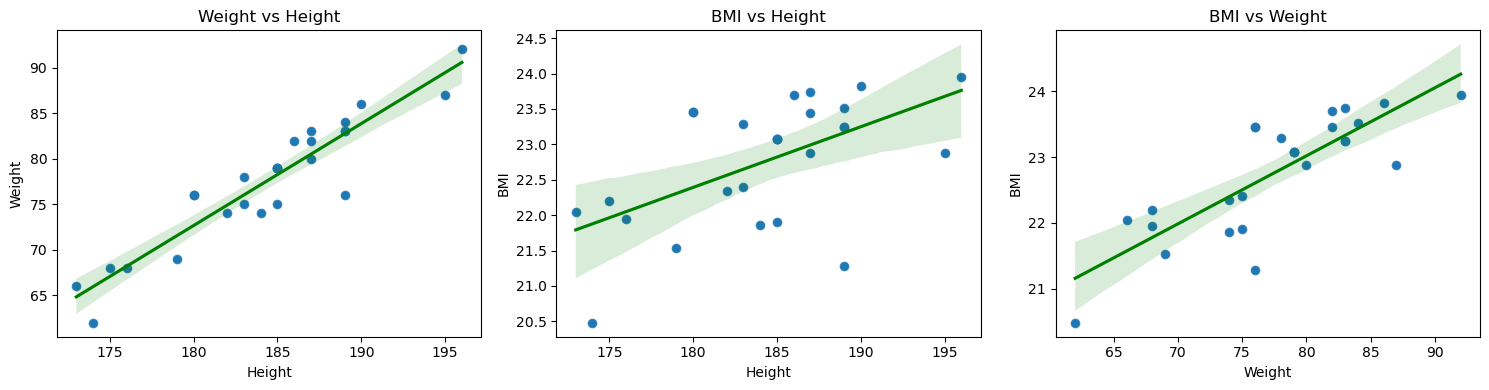

In [47]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

ax1 = axes[0]
sns.scatterplot(x='Height', y='Weight', data=df_mfoot, ax=ax1)
sns.regplot(x='Height', y='Weight', data=df_mfoot, ax=ax1, line_kws={'linestyle': 'solid', 'color': 'green'})
ax1.set_xlabel('Height')
ax1.set_ylabel('Weight')
ax1.set_title('Weight vs Height')

ax2 = axes[1]
sns.scatterplot(x='Height', y='BMI', data=df_mfoot, ax=ax2)
sns.regplot(x='Height', y='BMI', data=df_mfoot, ax=ax2, line_kws={'linestyle': 'solid', 'color': 'green'})
ax2.set_xlabel('Height')
ax2.set_ylabel('BMI')
ax2.set_title('BMI vs Height')

ax3 = axes[2]
sns.scatterplot(x='Weight', y='BMI', data=df_mfoot, ax=ax3)
sns.regplot(x='Weight', y='BMI', data=df_mfoot, ax=ax3, line_kws={'linestyle': 'solid', 'color': 'green'})
ax3.set_xlabel('Weight')
ax3.set_ylabel('BMI')
ax3.set_title('BMI vs Weight')

plt.tight_layout()
plt.show()

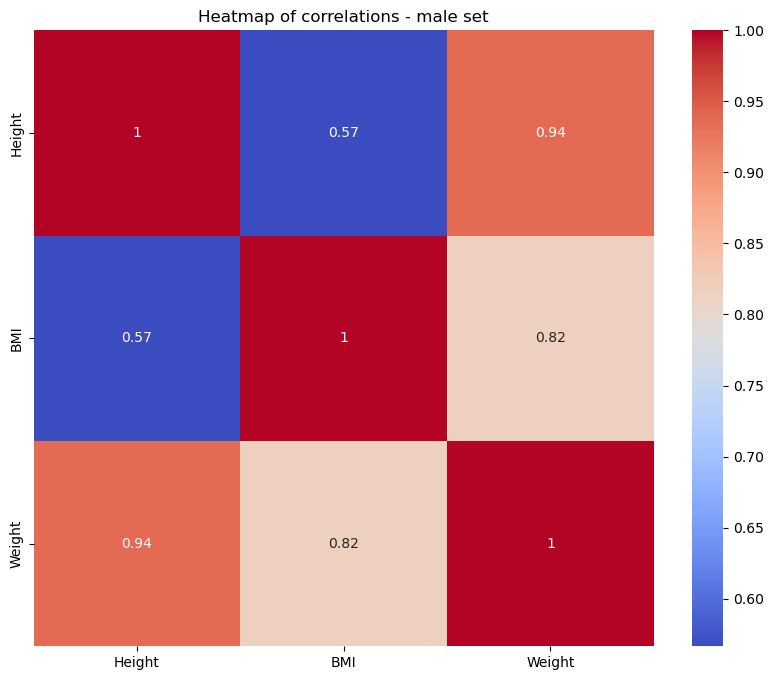

In [48]:
correlation_matrix = df_mfoot[continuous_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Heatmap of correlations - male set')
plt.show()

Tak jak można było przypuścić, testy normalności zakończyły się potwierdzeniem hipotez zerowych o pochodzeniu próbek z rozkładu normalnego. Wszystkie rozkłady mają ujemną skośność i kurtozę, co świadczy odpowiednio o lewostronnych skośnościach rozkładów i grubszych, bardziej spłaszczonych względem rozkładu normalnego ogonach.

In [37]:
normality_testing(df_mfoot, continuous_cols)

Column 'Height':

Shapiro-Wilk test statistic: 0.9647014141082764
Shapiro-Wilk p-value: 0.4923861026763916
------------------------------------
D'Agostino-Pearson test statistic: 0.19017149615435144
D'Agostino-Pearson p-value: 0.9092949608307577
------------------------------------
Anderson-Darling test statistic: 0.3785306050101731
Anderson-Darling critical values: [0.516 0.587 0.705 0.822 0.978]
Anderson-Darling significance level: [15.  10.   5.   2.5  1. ]
------------------------------------
Skewness: -0.1739323441425287
Kurtosis: -0.32371425022611344
------------------------------------

Column 'BMI':

Shapiro-Wilk test statistic: 0.9274125099182129
Shapiro-Wilk p-value: 0.06725762039422989
------------------------------------
D'Agostino-Pearson test statistic: 3.302102066397301
D'Agostino-Pearson p-value: 0.19184816382980416
------------------------------------
Anderson-Darling test statistic: 0.6856404758747097
Anderson-Darling critical values: [0.516 0.587 0.705 0.822 0.978]
A

To, co zaobserwowaliśmy przy okazji obserwacji statystyk opisowych, znalazło swoje odzwierciedlenie w testach istotności różnic. Wartości p dla każdego testu są bardzo niskie, co pozwala na przyjęcie hipotezy alternatywnej o istotnych różnicach między rozkładami zmiennych w populacji, a rozkładami zmiennych wśród piłkarzy. Statystyki testowe są ujemne w przypadku wagi i BMI oraz dodatnia w przypadku wzrostu; piłkarze ważą zatem z reguły względnie mniej i mają niższe BMI, ale są wyżsi.

In [50]:
distributions_comparison(df_mfoot, df_male, continuous_cols)

Column Height:
T-test statistic: 2.656848645191079
T-test p-value: 0.007912428241635145
------------------------------------
KS test statistic: 0.3257076923076923
KS test p-value: 0.006064046999495328
------------------------------------

Column BMI:
T-test statistic: -5.912783284247003
T-test p-value: 3.585949178438661e-09
------------------------------------
KS test statistic: 0.8048
KS test p-value: 1.425835486606388e-18
------------------------------------

Column Weight:
T-test statistic: -4.17991432904416
T-test p-value: 2.965764099305777e-05
------------------------------------
KS test statistic: 0.5228153846153846
KS test p-value: 4.1744409637745143e-07
------------------------------------



Teraz pora na stworzenie zbioru próbek dot. piłkarek.

In [39]:
female_best_polish_footballers = {
    'Height': [174, 170, 170, 174, 160, 161, 170, 162, 174, 166,
               160, 158, 172, 171, 180, 180, 166, 183, 169, 168,
               170, 170, 183, 168, 168, 154, 167], 
    'Weight': [76, 56, 60, 61, 51, 52, 55, 59, 58, 57, 50, 50,
               58, 58, 63, 62, 59, 69, 58, 56, 60, 68, 69, 56, 
               56, 50, 58]
}

df_femfoot = pd.DataFrame.from_dict(female_best_polish_footballers)
df_femfoot

,Height,Weight
0,174,76
1,170,56
2,170,60
3,174,61
4,160,51
5,161,52
6,170,55
7,162,59
8,174,58
9,166,57


In [40]:
df_femfoot['BMI'] = df_femfoot['Weight'] / ((df_femfoot['Height']/100)**2)
df_femfoot['BMI'] = round(df_femfoot['BMI'], 2)
df_femfoot

,Height,Weight,BMI
0,174,76,25.10
1,170,56,19.38
2,170,60,20.76
3,174,61,20.15
4,160,51,19.92
5,161,52,20.06
6,170,55,19.03
7,162,59,22.48
8,174,58,19.16
9,166,57,20.69


Również w tym wypadku widoczne są różnice między wzrostem, wagą i BMI piłkarek a ogółem wygenerowanego zbioru.

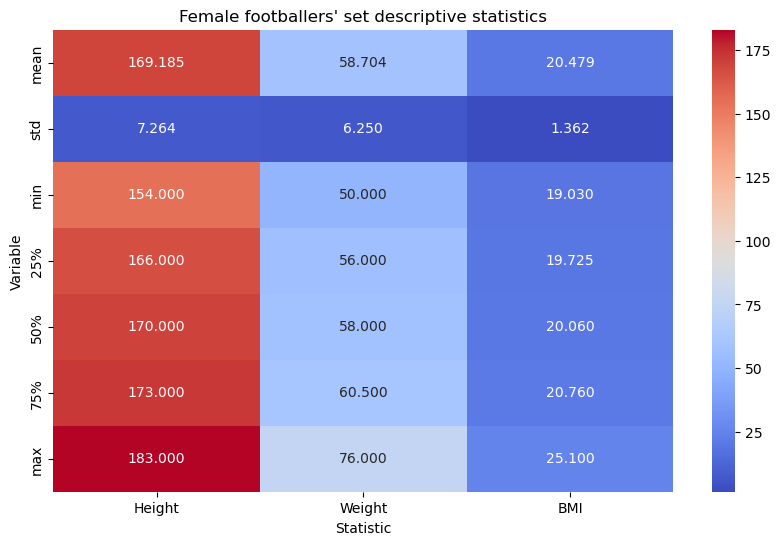

In [41]:
plt.figure(figsize=(10, 6))
sns.heatmap(df_femfoot.describe().drop('count'), annot=True, fmt=".3f", cmap='coolwarm')
plt.xlabel('Statistic')
plt.ylabel('Variable')
plt.title("Female footballers' set descriptive statistics")
plt.show()

Rozkłady wagi i BMI są prawostronnie skośne, rozkład dot. wzrostu jest nieco zbliżony do normalnego.

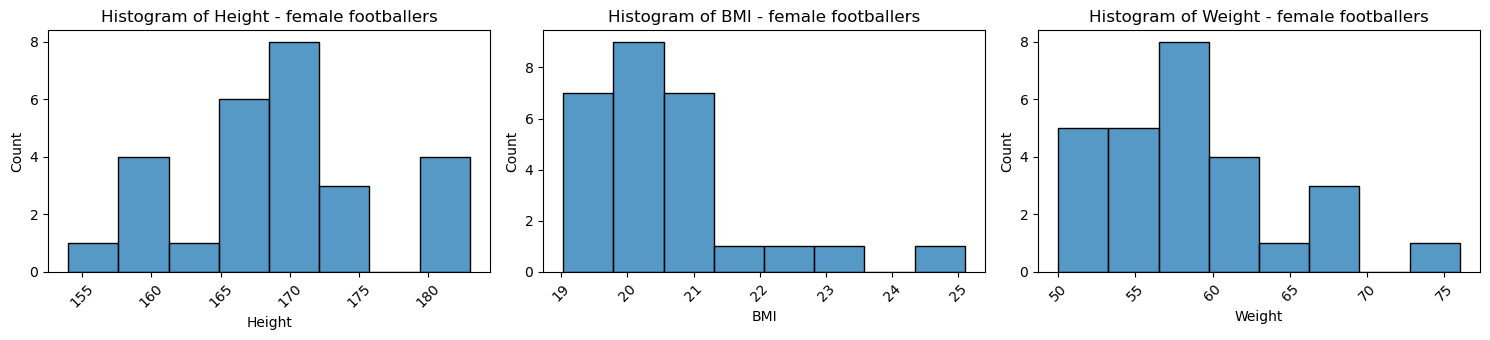

In [42]:
rotation = 45
legend = (1, 1)
figsize = (5, 3.5)

fig, axes = plt.subplots(1, 3, figsize=(15, 3.5)) 

for i, col in enumerate(continuous_cols):
    plt.subplot(1, 3, i+1) 
    ax = sns.histplot(x=col, data=df_femfoot, bins=8)
    plt.xticks(rotation=rotation)
    plt.title(f'Histogram of {col} - female footballers')

plt.tight_layout()
plt.show()

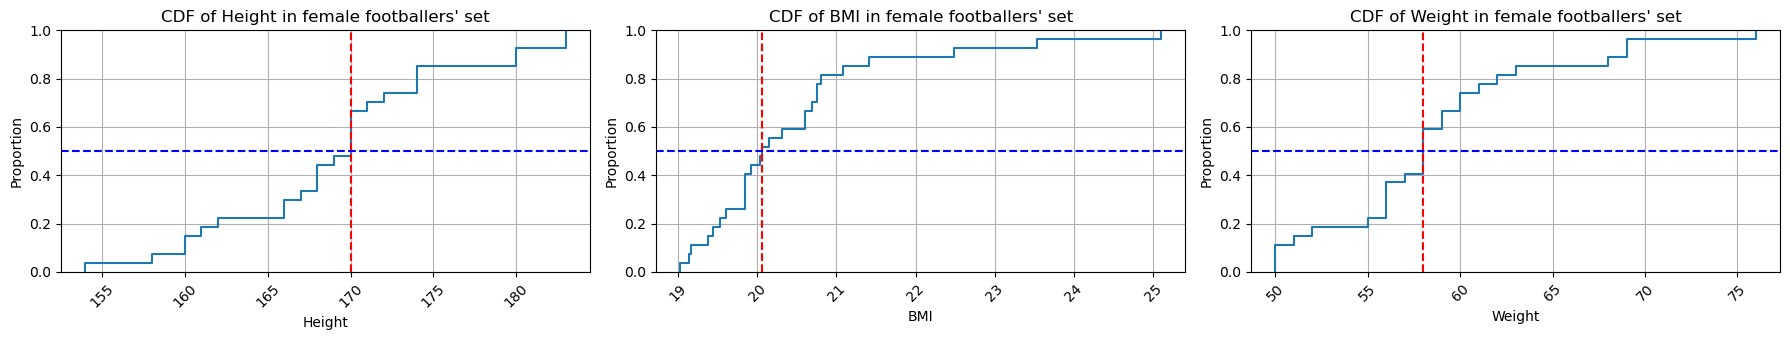

In [43]:
rotation = 45
legend = (1, 1)
figsize = (6, 3.5)

fig, axes = plt.subplots(1, 3, figsize=(18, 3.5)) 

for i, col in enumerate(continuous_cols):
    plt.subplot(1, 3, i+1) 
    ax = sns.ecdfplot(x=col, data=df_femfoot)
    plt.xticks(rotation=rotation)
    plt.grid(True)
    plt.title(f"CDF of {col} in female footballers' set")
    median = df_femfoot[col].median()
    plt.axvline(median, color='red', linestyle='--')
    plt.axhline(0.5, color='blue', linestyle='--')

plt.tight_layout()
plt.show()

U pań również silna jest zależność liniowa między wzrostem i wagą, ale zdarzają się też wartości wyraźnie odstające. Między BMI a wzrostem zachodzi nawet minimalna korelacja ujemna.

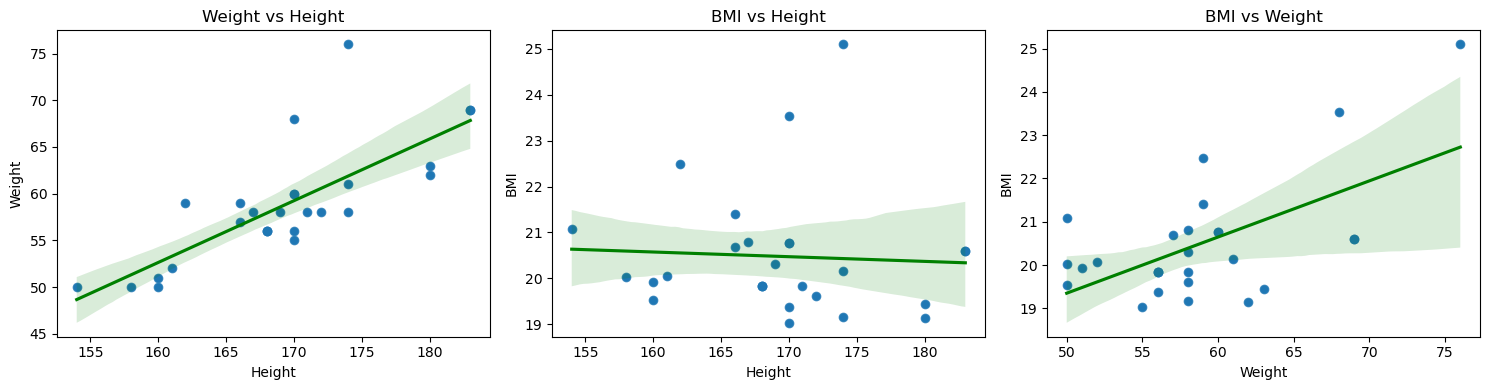

In [44]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

ax1 = axes[0]
sns.scatterplot(x='Height', y='Weight', data=df_femfoot, ax=ax1)
sns.regplot(x='Height', y='Weight', data=df_femfoot, ax=ax1, line_kws={'linestyle': 'solid', 'color': 'green'})
ax1.set_xlabel('Height')
ax1.set_ylabel('Weight')
ax1.set_title('Weight vs Height')

ax2 = axes[1]
sns.scatterplot(x='Height', y='BMI', data=df_femfoot, ax=ax2)
sns.regplot(x='Height', y='BMI', data=df_femfoot, ax=ax2, line_kws={'linestyle': 'solid', 'color': 'green'})
ax2.set_xlabel('Height')
ax2.set_ylabel('BMI')
ax2.set_title('BMI vs Height')

ax3 = axes[2]
sns.scatterplot(x='Weight', y='BMI', data=df_femfoot, ax=ax3)
sns.regplot(x='Weight', y='BMI', data=df_femfoot, ax=ax3, line_kws={'linestyle': 'solid', 'color': 'green'})
ax3.set_xlabel('Weight')
ax3.set_ylabel('BMI')
ax3.set_title('BMI vs Weight')

plt.tight_layout()
plt.show()

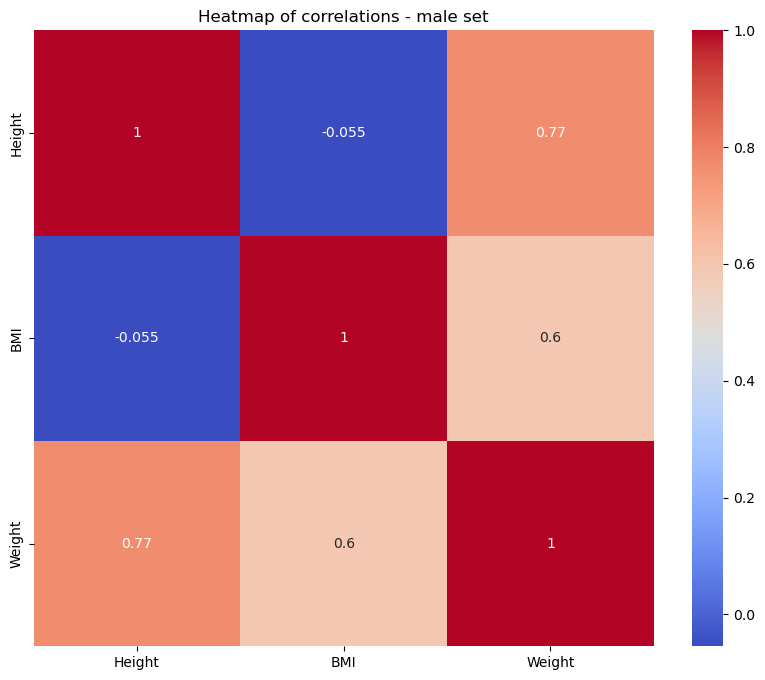

In [49]:
correlation_matrix = df_femfoot[continuous_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Heatmap of correlations - male set')
plt.show()

Wyniki testów normalności są bardziej złożone. Bez trudu hipoteza zerowa zostaje przyjęta w przypadku kolumny dot. wzrostu. W przypadku BMI statystyki testowe i p-wartości dla testów Shapiro-Wilka i D'Agostino-Pearsona wskazują na rozkład bliski normalnemu, ale statystyka testowa w teście Andersona-Darlinga przekracza wszystkie wartości krytyczne, co sugeruje odrzucenie hipotezy o pochodzeniu z rozkładu normalnego, do tego wysoka dodatnia skośność wskazuje na znaczną skośność prawostronną, a wysoka wartość kurtozy sugeruje, że rozkład jest bardziej szpiczasty w porównaniu do rozkładu normalnego. Co do kolumny dot. wagi, p-wartość w teście Shapiro-Wilka nie przekracza 0,05, zaś w teście D'Agostino-Pearsona przekracza ją minimalnie. Statystyka testowa w teście Andersona-Darlinga przekracza zaś tylko niektóre z wartości krytycznych. Skośność i kurtoza wskazują na niewielką lewostronną skośność i niewielkie spłaszczenie rozkładu względem normalnego. 

In [45]:
normality_testing(df_femfoot, continuous_cols)

Column 'Height':

Shapiro-Wilk test statistic: 0.9629731774330139
Shapiro-Wilk p-value: 0.43083420395851135
------------------------------------
D'Agostino-Pearson test statistic: 0.07092292337045783
D'Agostino-Pearson p-value: 0.9651599291504351
------------------------------------
Anderson-Darling test statistic: 0.44759870991708794
Anderson-Darling critical values: [0.517 0.589 0.707 0.824 0.98 ]
Anderson-Darling significance level: [15.  10.   5.   2.5  1. ]
------------------------------------
Skewness: 0.07346520583823228
Kurtosis: -0.24143241431022666
------------------------------------

Column 'BMI':

Shapiro-Wilk test statistic: 0.7963666915893555
Shapiro-Wilk p-value: 0.000118484822451137
------------------------------------
D'Agostino-Pearson test statistic: 22.264884189564462
D'Agostino-Pearson p-value: 1.4629915850676652e-05
------------------------------------
Anderson-Darling test statistic: 1.7175519090228164
Anderson-Darling critical values: [0.517 0.589 0.707 0.824 0

Nie rozwodząc się zbytnio nad badaniem istotności statystycznej różnic między próbką mniejszą a większą, należy wskazać, że wyniki są generalnie bliskie tym w zbiorach dot. mężczyzn: znaczne istotności, co do zasady większy wzrost piłkarek, ale mniejsza waga i BMI.

In [51]:
distributions_comparison(df_femfoot, df_female, continuous_cols)

Column Height:
T-test statistic: 2.7231126308214706
T-test p-value: 0.0064893364189033955
------------------------------------
KS test statistic: 0.2972666666666667
KS test p-value: 0.013397756590746398
------------------------------------

Column BMI:
T-test statistic: -8.269460125562032
T-test p-value: 1.7060340778679177e-16
------------------------------------
KS test statistic: 0.7946888888888889
KS test p-value: 1.2313245627771477e-18
------------------------------------

Column Weight:
T-test statistic: -6.04242125892972
T-test p-value: 1.6275816253247035e-09
------------------------------------
KS test statistic: 0.6368518518518519
KS test p-value: 4.241395664618029e-11
------------------------------------



# Podsumowanie.

Projekt ten służył wyłącznie generacji danych i ich dalszej analizie, co nie znaczy, że stworzonych w nim danych nie można wykorzystać w celu uczenia maszynowego. Stworzony przeze mnie zbiór danych może śmiało posłużyć do wykonywania prostych zadań z regresji czy klasyfikacji. Warto przy tym zaznaczyć, że możliwości tworzenia rozkładów danych - dzięki stworzeniu odpowiedniej klasy - są dość znaczne, do czego zachęcam każdego, kto uruchomi ten kod. 